In [1]:
import acquire
import pandas as pd
from string import digits
import explore
import requests
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
import statistics
import re
import unicodedata
import nltk

import ngrams
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from gensim.parsing.preprocessing import remove_stopwords

In [2]:
import sys
print(sys.getrecursionlimit())

3000


In [104]:
df = acquire.get_github_geology_results(cached=True)
df.head()

,language,content,date
0,Jupyter Notebook,hylite\nhylite is an open-source python packag...,2020-11-27 17:31:07.762
1,Python,\n\n\n\n\n\nWebviz subsurface\n\n✨👓 Live demo ...,2020-11-27 17:31:08.305
2,R,"Reforester\nReforester, an R program that:\n\n...",2020-11-27 17:31:08.926
3,JavaScript,Swissgeol NGM\nA Geology 3D viewer\nSwissgeol ...,2020-11-27 17:31:09.532
4,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,2020-11-27 17:31:10.206


In [105]:
df.head(20)

,language,content,date
0,Jupyter Notebook,hylite\nhylite is an open-source python packag...,2020-11-27 17:31:07.762
1,Python,\n\n\n\n\n\nWebviz subsurface\n\n✨👓 Live demo ...,2020-11-27 17:31:08.305
2,R,"Reforester\nReforester, an R program that:\n\n...",2020-11-27 17:31:08.926
3,JavaScript,Swissgeol NGM\nA Geology 3D viewer\nSwissgeol ...,2020-11-27 17:31:09.532
4,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,2020-11-27 17:31:10.206
5,Batchfile,Geoinformática aplicada a la cartografía multi...,2020-11-27 17:31:10.817
6,Jupyter Notebook,Automatic Rock Core Sample Marker\n\nAs we kno...,2020-11-27 17:31:11.414
7,TypeScript,Geological Models Portal\nPurpose\nNB: It is n...,2020-11-27 17:31:12.044
8,Jupyter Notebook,hylite\nhylite is an open-source python packag...,2020-11-27 17:31:12.886
9,Python,\n\n\n\n\n\nWebviz subsurface\n\n✨👓 Live demo ...,2020-11-27 17:31:13.263


In [4]:
###################################### Clean Data Function ###############################

def basic_clean(string):
    '''
    Converts text in to ascii to remove special characters, then converts back in to utf-8
    '''
    string = (unicodedata.normalize('NFKD', string.lower())
            .encode('ascii', 'ignore') # ascii to reduce noise
            .decode('utf-8', 'ignore') # decode using utf-8
           )
    string = re.sub(r"[^a-z0-9\s]", '', string)
     # Remove numbers from text
    string = re.sub(r'\d+', '', string)
    return string
    

def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()
    
    # Use tokenizer
    string = tokenizer.tokenize(string, return_str=True)
    
    return string

def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    
    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)
    
    return string


def remove_stopwords(string):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    # Create stopword_list.
    stopword_list = stopwords.words('english')
    #stopword_list = set(stopword_list).union(set(extra_words))
    #print(f"Lenght of stopword list before:{len(stopword_list)}")
    
    # Split words in string.
    words = string.split()
    
    # Create a list of words from my string with stopwords removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]
    
    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)
    return string_without_stopwords

    
def clean_data(df):
    '''
    This function takes in a dataframe of text, cleans, tokenizes, lemmatizes, and removes stopwords
    from that text, appending each step in the process to the dataframe.  It also appends a list of 
    words from each article as well as the total lenght.  
    '''    

    # Formatts repo contents to make them easier to read
    df['text_cleaned'] = df.content.apply(basic_clean)
    df['text_tokenized'] = df.text_cleaned.apply(tokenize)
    df['text_lemmatized'] = df.text_tokenized.apply(lemmatize)
    df['text_filtered'] = df.text_lemmatized.apply(remove_stopwords)
    # Add column with list of words
    words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.text_filtered]
    df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)
    # Adds column with lenght of word list
    df['doc_length'] = [len(wordlist) for wordlist in df.words]
    
    # Adds column with bigrams
    #df['bigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.ngrams(row.split(), 2)))
    df['bigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.bigrams(row.split(' '))))
    df['trigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.trigrams(row.split(' '))))
    
    # Specify dataframe content
    df = df[['language','text_filtered','doc_length','words','bigrams','trigrams']]
    #df = df['language','text_filtered','words','doc_length']
    
    # removing non-english languages 
    language_list = ['JavaScript', 'R', 'Jupyter Notebook','Python','TypeScript']
    df = df[df.language.isin(language_list)]
    return df

In [5]:
df1 = clean_data(df)
df1.head()

,language,text_filtered,doc_length,words,bigrams,trigrams
0,Jupyter Notebook,hylite hylite opensource python package prepro...,300,"[hylite, hylite, opensource, python, package, ...","[(hylite, hylite), (hylite, opensource), (open...","[(hylite, hylite, opensource), (hylite, openso..."
1,Python,webviz subsurface live demo application introd...,261,"[webviz, subsurface, live, demo, application, ...","[(webviz, subsurface), (subsurface, live), (li...","[(webviz, subsurface, live), (subsurface, live..."
2,R,reforester reforester r program us logistic bi...,771,"[reforester, reforesterprogram, us, logistic, ...","[(reforester, reforester), (reforester, r), (r...","[(reforester, reforester, r), (reforester, r, ..."
3,JavaScript,swissgeol ngm geology viewer swissgeol new geo...,120,"[swissgeol, ngm, geology, viewer, swissgeol, n...","[(swissgeol, ngm), (ngm, geology), (geology, v...","[(swissgeol, ngm, geology), (ngm, geology, vie..."
4,Python,geomodeldweb generates web version geological ...,174,"[geomodeldweb, generates, web, version, geolog...","[(geomodeldweb, generates), (generates, web), ...","[(geomodeldweb, generates, web), (generates, w..."


In [6]:
df1.language.value_counts()

Python              463
Jupyter Notebook    460
R                   232
TypeScript          229
JavaScript          229
Name: language, dtype: int64

In [7]:
df1.isnull().sum()

language         0
text_filtered    0
doc_length       0
words            0
bigrams          0
trigrams         0
dtype: int64

<div class="alert alert-block alert-info"><b></b></div>

***
## Hypothesis: 
`In the dicipline of Geology, specific programing languages are used for specific tasks.  In a dataset with 6 specific programing languages there should be 6 specific content groups identified using topic modeling
***

<div class="alert alert-block alert-info"><b></b></div>

## Remove Words with Ginsim Library (Install)

In this article, we will explore the Gensim library, which is another extremely useful NLP library for Python. Gensim was primarily developed for topic modeling. However, it now supports a variety of other NLP tasks such as converting words to vectors (word2vec), document to vectors (doc2vec), finding text similarity, and text summarization.

## Topic Modeling:

Topic modeling is an unsupervised technique that intends to analyze large volumes of text data by clustering the documents into groups. In the case of topic modeling, the text data do not have any labels attached to it. Rather, topic modeling tries to group the documents into clusters based on similar characteristics.

A typical example of topic modeling is clustering a large number of newspaper articles that belong to the same category. In other words, cluster documents that have the same topic. It is important to mention here that it is extremely difficult to evaluate the performance of topic modeling since there are no right answers. It depends upon the user to find similar characteristics between the documents of one cluster and assign it an appropriate label or topic.

### Latent Dirichlet Allocation (LDA)

The LDA is based upon two general assumptions:

    Documents that have similar words usually have the same topic
    Documents that have groups of words frequently occurring together usually have the same topic.

These assumptions make sense because the documents that have the same topic, for instance, Business topics will have words like the "economy", "profit", "the stock market", "loss", etc. The second assumption states that if these words frequently occur together in multiple documents, those documents may belong to the same category.

Mathematically, the above two assumptions can be represented as:

    Documents are probability distributions over latent topics
    Topics are probability distributions over words


<div class="alert alert-block alert-info"><b></b></div>

# First Round: Default Settings

<div class="alert alert-block alert-info"><b></b></div>

#### Topic Modeling: Step One (Applying LDA)

`Before we can apply LDA, we need to create vocabulary of all the words in our data. Remember from the previous article, we could do so with the help of a count vectorizer.`

`sklearn.feature_extraction.text module to create a document-term matrix. We specify to only include those words that appear in less than 80% of the document and appear in at least 2 documents. We also remove all the stop words as they do not really contribute to topic modeling.`

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df1['text_filtered'].values.astype('U'))
doc_term_matrix

<1613x886 sparse matrix of type '<class 'numpy.int64'>'
	with 257395 stored elements in Compressed Sparse Row format>

`Each of 2k documents is represented as 1066 dimensional vector, which means that our vocabulary has 1066 words.`

In [9]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

`In the script above we use the LatentDirichletAllocation class from the sklearn.decomposition library to perform LDA on our document-term matrix. The parameter n_components specifies the number of categories, or topics, that we want our text to be divided into. The parameter random_state (aka the seed) is set to 42 so that you get similar results each time.`

`Let's randomly fetch words from our vocabulary. We know that the count vectorizer contains all the words in our vocabulary. We can use the get_feature_names() method and pass it the ID of the word that we want to fetch.`

In [10]:
import random

for i in range(10):
    random_id = random.randint(0,len(count_vect.get_feature_names()))
    print(count_vect.get_feature_names()[random_id])

pointcloud
single
cesiumjs
mainuniformsamplingr
sg
set
reforesters
similarly
reconstruction
computing


`Let's find 10 words with the highest probability for the first topic. To get the first topic, you can use the components_ attribute and pass a 0 index as the value`

`The first topic contains the probabilities of 14546 words for topic To sort the indexes according to probability values, we can use the argsort() function. Once sorted, the 10 words with the highest probabilities will now belong to the last 10 indexes of the array. The following script returns the indexes of the 10 words with the highest probabilities:`

In [11]:
first_topic = LDA.components_[0]
top_topic_words = first_topic.argsort()[-10:]
top_topic_words

array([439,  95, 838, 561, 868, 639, 215, 492, 313, 268])

`These indexes can then be used to retrieve the value of the words from the count_vect object, which can be done like this`

In [12]:
for i in top_topic_words:
    print(count_vect.get_feature_names()[i])

library
clone
use
parameter
website
readme
documentation
model
gocad
file


`Let's print the 10 words with highest probabilities for all the five topics:`

In [13]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['library', 'clone', 'use', 'parameter', 'website', 'readme', 'documentation', 'model', 'gocad', 'file']


Top 10 words for topic #1:
['web', 'use', 'service', 'api', 'npm', 'server', 'directory', 'start', 'model', 'file']


Top 10 words for topic #2:
['subsurface', 'container', 'pip', 'check', 'install', 'application', 'github', 'run', 'repository', 'test']


Top 10 words for topic #3:
['tree', 'diversity', 'rate', 'data', 'time', 'using', 'sampling', 'simulation', 'run', 'fossil']


Top 10 words for topic #4:
['directory', 'library', 'using', 'gdal', 'spectral', 'import', 'python', 'data', 'install', 'hylite']




`As a final step, we will add a column to the original data frame that will store the topic for the text. To do so, we can use LDA.transform() method and pass it our document-term matrix. This method will assign the probability of all the topics to each document. Look at the following code:`

In [14]:
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

(1613, 5)

`n the output, you will see (1613, 5) which means that each of the document has 5 columns where each column corresponds to the probability value of a particular topic. To find the topic index with maximum value, we can call the argmax() method and pass 1 as the value for the axis parameter.`

`The following script adds a new column for topic in the data frame and assigns the topic value to each row in the column:`

In [15]:
df1['Topic'] = topic_values.argmax(axis=1)
df1.head(10)

,language,text_filtered,doc_length,words,bigrams,trigrams,Topic
0,Jupyter Notebook,hylite hylite opensource python package prepro...,300,"[hylite, hylite, opensource, python, package, ...","[(hylite, hylite), (hylite, opensource), (open...","[(hylite, hylite, opensource), (hylite, openso...",4
1,Python,webviz subsurface live demo application introd...,261,"[webviz, subsurface, live, demo, application, ...","[(webviz, subsurface), (subsurface, live), (li...","[(webviz, subsurface, live), (subsurface, live...",2
2,R,reforester reforester r program us logistic bi...,771,"[reforester, reforesterprogram, us, logistic, ...","[(reforester, reforester), (reforester, r), (r...","[(reforester, reforester, r), (reforester, r, ...",3
3,JavaScript,swissgeol ngm geology viewer swissgeol new geo...,120,"[swissgeol, ngm, geology, viewer, swissgeol, n...","[(swissgeol, ngm), (ngm, geology), (geology, v...","[(swissgeol, ngm, geology), (ngm, geology, vie...",1
4,Python,geomodeldweb generates web version geological ...,174,"[geomodeldweb, generates, web, version, geolog...","[(geomodeldweb, generates), (generates, web), ...","[(geomodeldweb, generates, web), (generates, w...",0
6,Jupyter Notebook,automatic rock core sample marker know marking...,47,"[automatic, rock, core, sample, marker, know, ...","[(automatic, rock), (rock, core), (core, sampl...","[(automatic, rock, core), (rock, core, sample)...",3
7,TypeScript,geological model portal purpose nb fully devel...,329,"[geological, model, portal, purpose, nb, fully...","[(geological, model), (model, portal), (portal...","[(geological, model, portal), (model, portal, ...",1
8,Jupyter Notebook,hylite hylite opensource python package prepro...,300,"[hylite, hylite, opensource, python, package, ...","[(hylite, hylite), (hylite, opensource), (open...","[(hylite, hylite, opensource), (hylite, openso...",4
9,Python,webviz subsurface live demo application introd...,261,"[webviz, subsurface, live, demo, application, ...","[(webviz, subsurface), (subsurface, live), (li...","[(webviz, subsurface, live), (subsurface, live...",2
10,R,reforester reforester r program us logistic bi...,771,"[reforester, reforesterprogram, us, logistic, ...","[(reforester, reforester), (reforester, r), (r...","[(reforester, reforester, r), (reforester, r, ...",3


In [16]:
df1.Topic.value_counts()

3    460
1    458
4    232
2    232
0    231
Name: Topic, dtype: int64

In [17]:
df1.language.value_counts()

Python              463
Jupyter Notebook    460
R                   232
TypeScript          229
JavaScript          229
Name: language, dtype: int64

***

#### Create wordlist for visualization

In [18]:
t0_words = ' '.join(df1[df1.Topic ==0].text_filtered)
t1_words = ' '.join(df1[df1.Topic ==1].text_filtered)
t2_words = ' '.join(df1[df1.Topic ==2].text_filtered)
t3_words = ' '.join(df1[df1.Topic ==3].text_filtered)
t4_words = ' '.join(df1[df1.Topic ==4].text_filtered)

#### Most Frequent Words

In [19]:
t0_freq = pd.Series(t0_words.split()).value_counts()
t1_freq = pd.Series(t1_words.split()).value_counts()
t2_freq = pd.Series(t2_words.split()).value_counts()
t3_freq = pd.Series(t3_words.split()).value_counts()
t4_freq = pd.Series(t4_words.split()).value_counts()

#### Create Word Counts

In [20]:
word_counts = (pd.concat([t0_freq, t1_freq, t2_freq, t3_freq, t4_freq], axis =1, sort =True)
               .set_axis(['t0', 't1', 't2', 't3', 't4'], axis = 1, inplace = False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

In [21]:
#Top 10 most frequently occuring words
word_counts.sort_values(by='t0', ascending =False).head(10)

,t0,t1,t2,t3,t4
file,1848,3435,928,1856,0
gocad,1155,458,0,0,0
model,924,3206,0,1624,0
readme,693,0,0,232,0
v,693,0,0,928,0
documentation,693,0,696,0,232
website,693,916,0,0,0
geomodeldweb,462,0,0,0,0
python,462,687,232,0,1392
pyassimp,462,0,0,0,0


***

#### Topic 0

In [22]:
topic0 =df1[df1.Topic == 0]
topic0.language.value_counts()

Python    231
Name: language, dtype: int64

#### Wordcloud Topic 0

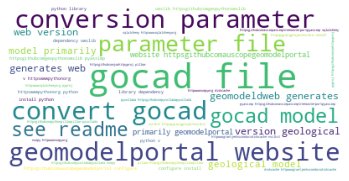

In [23]:
img = WordCloud(background_color='white').generate(t0_words)
plt.imshow(img)
plt.axis('off')
plt.show()

***

#### Topic 1

In [24]:
topic1 =df1[df1.Topic == 1]
topic1.language.value_counts()

TypeScript    229
JavaScript    229
Name: language, dtype: int64

#### Wordcloud Topic 1

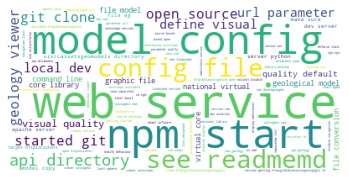

In [25]:
img = WordCloud(background_color='white').generate(t1_words)
plt.imshow(img)
plt.axis('off')
plt.show()

***

#### Topic 2

In [26]:
topic2 =df1[df1.Topic == 2]
topic2.language.value_counts()

Python    232
Name: language, dtype: int64

#### Wordcloud Topic 2

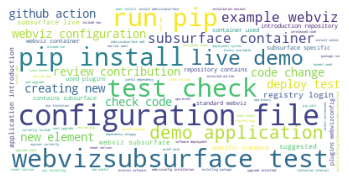

In [27]:
img = WordCloud(background_color='white').generate(t2_words)
plt.imshow(img)
plt.axis('off')
plt.show()

***

#### Topic 3

In [28]:
topic3 =df1[df1.Topic == 3]
topic3.language.value_counts()

R                   232
Jupyter Notebook    228
Name: language, dtype: int64

#### Wordcloud Topic 3

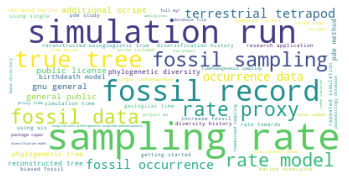

In [29]:
img = WordCloud(background_color='white').generate(t3_words)
plt.imshow(img)
plt.axis('off')
plt.show()

***

#### Topic 4

In [30]:
topic4 =df1[df1.Topic == 4]
topic4.language.value_counts()

Jupyter Notebook    232
Name: language, dtype: int64

#### Wordcloud Topic 4

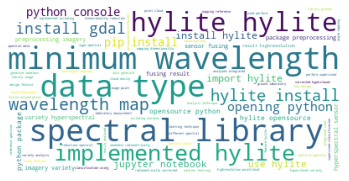

In [31]:
img = WordCloud(background_color='white').generate(t4_words)
plt.imshow(img)
plt.axis('off')
plt.show()

***

#### Takeaway:
Appears to be too many groups to correctly identify language, redo with 3 groups

<div class="alert alert-block alert-info"><b></b></div>

# Second Round: max_df = .20 (appear less than 20% of time) ie. more specific

<div class="alert alert-block alert-info"><b></b></div>

In [32]:
df2 = acquire.get_github_geology_results(cached=True)
df2 = clean_data(df2)
count_vect = CountVectorizer(max_df=0.2, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df2['text_filtered'].values.astype('U'))
LDA = LatentDirichletAllocation(n_components=3, random_state=42)
LDA.fit(doc_term_matrix)
topic_values = LDA.transform(doc_term_matrix)
df2['Topic'] = topic_values.argmax(axis=1)
df2.head()

,language,text_filtered,doc_length,words,bigrams,trigrams,Topic
0,Jupyter Notebook,hylite hylite opensource python package prepro...,300,"[hylite, hylite, opensource, python, package, ...","[(hylite, hylite), (hylite, opensource), (open...","[(hylite, hylite, opensource), (hylite, openso...",2
1,Python,webviz subsurface live demo application introd...,261,"[webviz, subsurface, live, demo, application, ...","[(webviz, subsurface), (subsurface, live), (li...","[(webviz, subsurface, live), (subsurface, live...",1
2,R,reforester reforester r program us logistic bi...,771,"[reforester, reforesterprogram, us, logistic, ...","[(reforester, reforester), (reforester, r), (r...","[(reforester, reforester, r), (reforester, r, ...",2
3,JavaScript,swissgeol ngm geology viewer swissgeol new geo...,120,"[swissgeol, ngm, geology, viewer, swissgeol, n...","[(swissgeol, ngm), (ngm, geology), (geology, v...","[(swissgeol, ngm, geology), (ngm, geology, vie...",1
4,Python,geomodeldweb generates web version geological ...,174,"[geomodeldweb, generates, web, version, geolog...","[(geomodeldweb, generates), (generates, web), ...","[(geomodeldweb, generates, web), (generates, w...",0


In [33]:
df2.Topic.value_counts()

0    688
2    464
1    461
Name: Topic, dtype: int64

In [34]:
# Create words for visulization
t0_words = ' '.join(df2[df2.Topic ==0].text_filtered)
t1_words = ' '.join(df2[df2.Topic ==1].text_filtered)
t2_words = ' '.join(df2[df2.Topic ==2].text_filtered)

In [35]:
#Topic 0
topic0 =df2[df2.Topic == 0]
topic0.language.value_counts()

Python              231
TypeScript          229
Jupyter Notebook    228
Name: language, dtype: int64

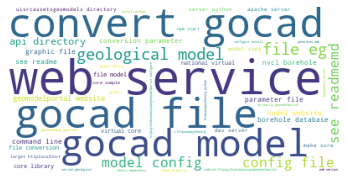

In [36]:
img = WordCloud(background_color='white').generate(t0_words)
plt.imshow(img)
plt.axis('off')
plt.show()

In [37]:
#Topic 1
topic1 =df2[df2.Topic == 1]
topic1.language.value_counts()

Python        232
JavaScript    229
Name: language, dtype: int64

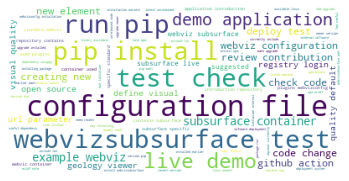

In [38]:
img = WordCloud(background_color='white').generate(t1_words)
plt.imshow(img)
plt.axis('off')
plt.show()

In [39]:
#Topic 2
topic2 =df2[df2.Topic == 2]
topic2.language.value_counts()

R                   232
Jupyter Notebook    232
Name: language, dtype: int64

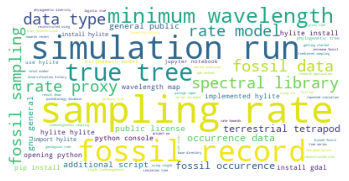

In [40]:
img = WordCloud(background_color='white').generate(t2_words)
plt.imshow(img)
plt.axis('off')
plt.show()

#### Takeaway:
Appears that there are more than 3 or 5 topics, lets try 10.  

<div class="alert alert-block alert-info"><b></b></div>

<div class="alert alert-block alert-info"><b></b></div>

# Filtered Data Set: Default Settings

In [41]:
df3 = acquire.get_github_geology_results(cached=True)

In [42]:
###################################### Clean Data Function ###############################

def basic_clean(string):
    '''
    Converts text in to ascii to remove special characters, then converts back in to utf-8
    '''
    string = (unicodedata.normalize('NFKD', string.lower())
            .encode('ascii', 'ignore') # ascii to reduce noise
            .decode('utf-8', 'ignore') # decode using utf-8
           )
    string = re.sub(r"[^a-z0-9\s]", '', string)
     # Remove numbers from text
    string = re.sub(r'\d+', '', string)
    return string
    

def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()
    
    # Use tokenizer
    string = tokenizer.tokenize(string, return_str=True)
    
    return string

def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    
    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)
    
    return string


def remove_extra_words(string):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    extra_words=['accessing',
     'according',
     'account',
     'accuracy',
     'accurate',
     'acknowledgement',
     'acquired',
     'across',
     'activate',
     'addition',
     'additional',
     'adhere',
     'adheres',
     'aim',
     'al',
     'along',
     'also',
     'alternative',
     'anacona',
     'anaconda',
     'analyse',
     'analysed',
     'analysis',
     'andor',
     'answer',
     'appearance',
     'application',
     'assetids',
     'associated',
     'assumption',
     'attempt',
     'author',
     'automated',
     'automatic',
     'available',
     'based',
     'behavior',
     'behaviour',
     'benson',
     'better',
     'bias',
     'biased',
     'billie',
     'birthdeath',
     'bug',
     'calculated',
     'cannot',
     'caper',
     'capture',
     'carried',
     'cause',
     'cc',
     'cc ',
     'cd',
     'check',
     'cite',
     'citing',
     'clone',
     'closer',
     'cloud',
     'cloudquickplotcloudheadergetcamera',
     'code',
     'coma',
     'commented',
     'common',
     'compared',
     'complete',
     'completeness',
     'conda',
     'consistently',
     'console',
     'contributing',
     'conventionally',
     'cool',
     'copytxt',
     'corescannerhypercloud',
     'corescannerhypercloud ',
     'corrected',
     'correction',
     'could',
     'count',
     'cpu',
     'create',
     'created',
     'currently',
     'daniel',
     'data',
     'database',
     'dataimporterr',
     'datasets',
     'default',
     'define',
     'derivative',
     'design',
     'desired',
     'detailed',
     'dev',
     'developingmd',
     'different',
     'difficult',
     'dimensionality',
     'directory',
     'disable',
     'disables',
     'display',
     'dissertation',
     'diversitydependent',
     'documentation',
     'doe',
     'download',
     'downloading',
     'dtilesets',
     'due',
     'earth',
     'easily',
     'efficiently',
     'eg',
     'empirical',
     'end',
     'enforce',
     'entierty',
     'enviroment',
     'environment',
     'equilibrium',
     'error',
     'estimate',
     'estimation',
     'et',
     'even',
     'example',
     'except',
     'explosion',
     'exponentially',
     'exponentiallydiversifying',
     'extant',
     'extend',
     'factor',
     'fast',
     'feature',
     'feel',
     'file',
     'find',
     'fine',
     'fix',
     'following',
     'format',
     'foundation',
     'free',
     'function',
     'functionssavesetsr',
     'functionsuniformsamplingr',
     'gdal',
     'general',
     'generate',
     'generating',
     'geological',
     'geology',
     'get',
     'getting',
     'git',
     'github',
     'gnu',
     'google',
     'ground',
     'ha',
     'happy',
     'hardcoded',
     'high',
     'highresolution',
     'history',
     'hope',
     'httplocalhost',
     'httpsbetaswissgeolch',
     'httpsgithubcomswissgeolngmgit',
     'httpshylitereadthedocsioenlatestindexhtml',
     'httpsopengameartorgcontenttemplateorangetexturepack',
     'httpswwwgnuorglicenses',
     'hylitergb',
     'hyperclouds',
     'id',
     'idea',
     'image',
     'imagine',
     'implemented',
     'implied',
     'import',
     'inaccurate',
     'included',
     'includes',
     'including',
     'indicate',
     'inferred',
     'information',
     'initialscreenspaceerror',
     'inspector',
     'install',
     'installation',
     'installed',
     'integrated',
     'integration',
     'introduces',
     'inverse',
     'io',
     'ioloadtestdatahypercloudplycloudquickplotcloudheadergetcamera',
     'ioloadtestdataimagehdrimagequickplothylitergb',
     'ioloadtestdatalibrarycsvlibquickplot',
     'issue',
     'json',
     'jupyter',
     'key',
     'keyboard',
     'keyboardlayouteditor',
     'know',
     'laboratory',
     'launch',
     'launching',
     'layout',
     'learning',
     'least',
     'length',
     'level',
     'lib',
     'libquickplot',
     'library',
     'licencemd',
     'license',
     'limit',
     'lineagecombining',
     'list',
     'local',
     'localhost',
     'localhost ',
     'long',
     'longheld',
     'lorenz',
     'machine',
     'made',
     'maintainerpackage',
     'make',
     'many',
     'map',
     'marineeumetazoacsv',
     'mark',
     'marker',
     'marking',
     'matplotlib',
     'maximum',
     'maximumscreenspaceerror',
     'merchantability',
     'method',
     'mind',
     'minimum',
     'modify',
     'multiscale',
     'must',
     'myr',
     'myrs',
     'navigate',
     'navigation',
     'need',
     'new',
     'next',
     'ngm',
     'nolimit',
     'nolimitfalse',
     'norequestrendermode',
     'note',
     'notebook',
     'npm',
     'number',
     'numpy',
     'occurrence',
     'one',
     'open',
     'opencv',
     'opening',
     'openpit',
     'opensource',
     'operation',
     'optimization',
     'optional',
     'order',
     'originatorclose',
     'ouput',
     'outdoor',
     'ownterrainfalse',
     'oxford',
     'package',
     'parameter',
     'partially',
     'particular',
     'past',
     'pattern',
     'pde',
     'pdes',
     'perform',
     'performed',
     'phytools',
     'pip',
     'placed',
     'please',
     'point',
     'pointcloud',
     'possible',
     'potential',
     'preform',
     'preprocessing',
     'prerequisitev',
     'prerequisitewindowv',
     'present',
     'prevented',
     'problem',
     'processing',
     'produce',
     'produce ',
     'produce',
     ' produce ',           
     'produced',
     'produced ',
     'program',
     'project',
     'project ',
     'prompt',
     'properly',
     'provide',
     'provided',
     'proxy',
     'public',
     'publically',
     'published',
     'pull',
     'purpose',
     'python',
     'quality',
     'question',
     'r',
     'rock',            
     'rather',
     'raw',
     'readme',
     'received',
     'recent',
     'record',
     'rectangle',
     'redistribute',
     'reduction',
     'refer',
     'reference',
     'referred',
     'reforester',
     'regime',
     'reinterpretation',
     'report',
     'repository',
     'request',
     'requires',
     'research',
     'resource',
     'respectively',
     'restrict',
     'restriction',
     'result',
     'results',
     'reults',
     'review',
     'rigorous',
     'roger',
     'run',
     'running',
     'said',
     'sample',
     'sampled',
     'sampling',
     'scan',
     'scene',
     'script',
     'seamless',
     'second',
     'section',
     'see',
     'separated',
     'server',
     'set',
     'setuppy',
     'setuptools',
     'significant',
     'significantly',
     'similarly',
     'simple',
     'slight',
     'software',
     'solved',
     'source',
     'specie',
     'specific',
     'specifically',
     'sphere',
     'start',
     'started',
     'stay',
     'step',
     'still',
     'study',
     'style',
     'submit',
     'sufficiently',
     'suggests',
     'supervised',
     'sure',
     'swiss',
     'swissgeol',
     'swissrectangle',
     'swissrectanglefalse',
     'swisstopo',
     'take',
     'technique',
     'technology',
     'template',
     'templatelogistic',
     'templatenotebooks',
     'term',
     'terminal',
     'test',
     'testdatahypercloudply',
     'testdataimagehdr',
     'testdatalibrarycsv',
     'testing',
     'texture',
     'theoretically',
     'thereby',
     'thiele',
     'thing',
     'thompson',
     'though',
     'tidyverse',
     'time',
     'timeheterogeneous',
     'tool',
     'touchdirectly',
     'true',
     'try',
     'trying',
     'tuned',
     'type',
     'typing',
     'ubiquity',
     'understanding',
     'unfortunately',
     'unsupervised',
     'unzip',
     'url',
     'us',
     'use',
     'used',
     'userhylite'
     'userhylite ',
     'userhyliterequired',
     'using',
     'value',
     'variety',
     'vast',
     'version',
     'viewed',
     'viewer',
     'visual',
     'wa',
     'want',
     'way',
     'welcome',
     'welcomed',
     'widget',
     'window',
     'word',
     'work',
     'project',
     'workflow']
    
    # Remove stopwords with Gensim Library
   # string.apply(remove_stopwords)
    
    # Create stopword_list.
    stopword_list = extra_words
    
    # Split words in string.
    words = string.split()
    
    # Create a list of words from my string with common words removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]
    
    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)
    return string_without_stopwords

    
def clean_data2(df):
    '''
    This function takes in a dataframe of text, cleans, tokenizes, lemmatizes, and removes stopwords
    from that text, appending each step in the process to the dataframe.  It also appends a list of 
    words from each article as well as the total lenght.  
    '''    

    # Formatts repo contents to make them easier to read
    df['text_cleaned'] = df.content.apply(basic_clean)
    df['text_tokenized'] = df.text_cleaned.apply(tokenize)
    df['text_lemmatized'] = df.text_tokenized.apply(lemmatize)
    df['text_filtered'] = df.text_lemmatized.apply(remove_stopwords)
    df['text_filtered'] = df.text_lemmatized.apply(remove_extra_words)
    # Add column with list of words
    words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.text_filtered]
    df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)
    # Adds column with lenght of word list
    df['doc_length'] = [len(wordlist) for wordlist in df.words]
    
    # Adds column with bigrams
    #df['bigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.ngrams(row.split(), 2)))
    df['bigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.bigrams(row.split(' '))))
    df['trigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.trigrams(row.split(' '))))
    
    # Specify dataframe content
    df = df[['language','text_filtered','doc_length','words','bigrams','trigrams']]
    #df = df['language','text_filtered','words','doc_length']
    
    # removing non-english languages 
    language_list = ['JavaScript', 'R', 'Jupyter Notebook','Python','TypeScript']
    df = df[df.language.isin(language_list)]
    return df

In [43]:
df3 = clean_data2(df)

In [44]:
count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df3['text_filtered'].values.astype('U'))
LDA = LatentDirichletAllocation(n_components=20, random_state=42)
LDA.fit(doc_term_matrix)
topic_values = LDA.transform(doc_term_matrix)
df3['Topic'] = topic_values.argmax(axis=1)
df3.head()

,language,text_filtered,doc_length,words,bigrams,trigrams,Topic
0,Jupyter Notebook,hylite hylite is an for imagery from a of hype...,172,"[hylite, hylite, is, an, for, imagery, fromof,...","[(hylite, hylite), (hylite, is), (is, an), (an...","[(hylite, hylite, is), (hylite, is, an), (is, ...",6
1,Python,webviz subsurface live demo introduction this ...,292,"[webviz, subsurface, live, demo, introduction,...","[(webviz, subsurface), (subsurface, live), (li...","[(webviz, subsurface, live), (subsurface, live...",7
2,R,an that a logistic model to simulated phylogen...,753,"[an, thatlogistic, model, to, simulated, phylo...","[(an, that), (that, a), (a, logistic), (logist...","[(an, that, a), (that, a, logistic), (a, logis...",11
3,JavaScript,a d is the d of at it is and on the cesiumjs d...,61,"[ais, theof, at, it, is, and, on, the, cesiumj...","[(a, d), (d, is), (is, the), (the, d), (d, of)...","[(a, d, is), (d, is, the), (is, the, d), (the,...",19
4,Python,geomodeldweb generates d web of model primaril...,164,"[geomodeldweb, generatesweb, of, model, primar...","[(geomodeldweb, generates), (generates, d), (d...","[(geomodeldweb, generates, d), (generates, d, ...",18


In [45]:
df3.Topic.value_counts()

11    232
7     232
6     232
18    231
19    229
13    229
15    228
Name: Topic, dtype: int64

In [46]:
t11_words = ' '.join(df3[df3.Topic ==11].text_filtered)
t7_words = ' '.join(df3[df3.Topic ==7].text_filtered)
t6_words = ' '.join(df3[df3.Topic ==6].text_filtered)
t18_words = ' '.join(df3[df3.Topic ==18].text_filtered)
t19_words = ' '.join(df3[df3.Topic ==19].text_filtered)
t13_words = ' '.join(df3[df3.Topic ==13].text_filtered)
t15_words = ' '.join(df3[df3.Topic ==15].text_filtered)

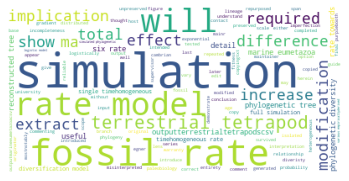

In [47]:
img = WordCloud(background_color='white').generate(t11_words)
plt.imshow(img)
plt.axis('off')
plt.show()

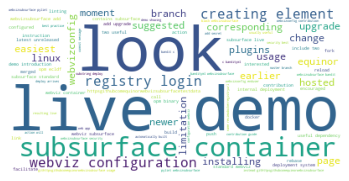

In [48]:
img = WordCloud(background_color='white').generate(t7_words)
plt.imshow(img)
plt.axis('off')
plt.show()

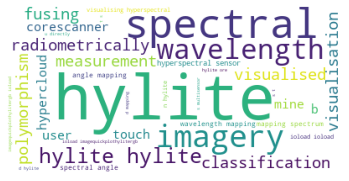

In [49]:
img = WordCloud(background_color='white').generate(t6_words)
plt.imshow(img)
plt.axis('off')
plt.show()

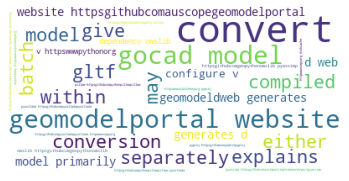

In [50]:
img = WordCloud(background_color='white').generate(t18_words)
plt.imshow(img)
plt.axis('off')
plt.show()

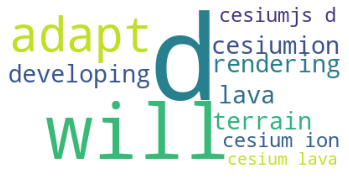

In [51]:
img = WordCloud(background_color='white').generate(t19_words)
plt.imshow(img)
plt.axis('off')
plt.show()

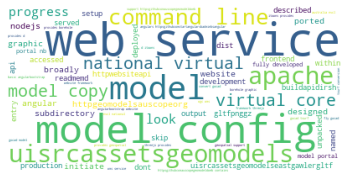

In [52]:
img = WordCloud(background_color='white').generate(t13_words)
plt.imshow(img)
plt.axis('off')
plt.show()

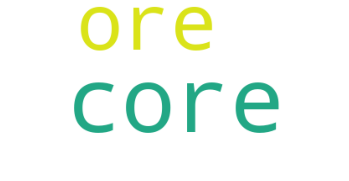

In [53]:
img = WordCloud(background_color='white').generate(t15_words)
plt.imshow(img)
plt.axis('off')
plt.show()

<div class="alert alert-block alert-info"><b></b></div>

<div class="alert alert-block alert-info"><b></b></div>

# Filtered Data Set:  max_df = 0.2, min_def = 6

In [54]:
df4 = acquire.get_github_geology_results(cached=True)
df4 = clean_data2(df)
count_vect = CountVectorizer(max_df=0.2, min_df=6, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df4['text_filtered'].values.astype('U'))
LDA = LatentDirichletAllocation(n_components=20, random_state=42)
LDA.fit(doc_term_matrix)
topic_values = LDA.transform(doc_term_matrix)
df4['Topic'] = topic_values.argmax(axis=1)
df4.head()

,language,text_filtered,doc_length,words,bigrams,trigrams,Topic
0,Jupyter Notebook,hylite hylite is an for imagery from a of hype...,172,"[hylite, hylite, is, an, for, imagery, fromof,...","[(hylite, hylite), (hylite, is), (is, an), (an...","[(hylite, hylite, is), (hylite, is, an), (is, ...",17
1,Python,webviz subsurface live demo introduction this ...,292,"[webviz, subsurface, live, demo, introduction,...","[(webviz, subsurface), (subsurface, live), (li...","[(webviz, subsurface, live), (subsurface, live...",2
2,R,an that a logistic model to simulated phylogen...,753,"[an, thatlogistic, model, to, simulated, phylo...","[(an, that), (that, a), (a, logistic), (logist...","[(an, that, a), (that, a, logistic), (a, logis...",3
3,JavaScript,a d is the d of at it is and on the cesiumjs d...,61,"[ais, theof, at, it, is, and, on, the, cesiumj...","[(a, d), (d, is), (is, the), (the, d), (d, of)...","[(a, d, is), (d, is, the), (is, the, d), (the,...",1
4,Python,geomodeldweb generates d web of model primaril...,164,"[geomodeldweb, generatesweb, of, model, primar...","[(geomodeldweb, generates), (generates, d), (d...","[(geomodeldweb, generates, d), (generates, d, ...",11


In [55]:
df4.language.value_counts()

Python              463
Jupyter Notebook    460
R                   232
TypeScript          229
JavaScript          229
Name: language, dtype: int64

In [56]:
df4.Topic.value_counts()

17    232
3     232
2     232
11    231
9     229
1     229
0     228
Name: Topic, dtype: int64

In [57]:
t17_len = df4[df4.Topic ==17].doc_length
t17_len

0       172
8       172
16      172
24      172
32      172
       ... 
1804    172
1812    172
1820    172
1828    172
1836    172
Name: doc_length, Length: 232, dtype: int64

In [58]:
t17_words = ' '.join(df4[df4.Topic ==17].text_filtered)
t3_words = ' '.join(df4[df4.Topic ==3].text_filtered)
t2_words = ' '.join(df4[df4.Topic ==2].text_filtered)
t11_words = ' '.join(df4[df4.Topic ==11].text_filtered)
t9_words = ' '.join(df4[df4.Topic ==9].text_filtered)
t1_words = ' '.join(df4[df4.Topic ==1].text_filtered)
t0_words = ' '.join(df4[df4.Topic ==0].text_filtered)

In [59]:
t17_freq = pd.Series(t17_words.split()).value_counts()
t3_freq = pd.Series(t3_words.split()).value_counts()
t2_freq = pd.Series(t2_words.split()).value_counts()
t11_freq = pd.Series(t11_words.split()).value_counts()
t9_freq = pd.Series(t9_words.split()).value_counts()
t1_freq = pd.Series(t1_words.split()).value_counts()
t0_freq = pd.Series(t0_words.split()).value_counts()

In [60]:
word_counts = (pd.concat([t17_freq, t3_freq, t2_freq, t11_freq, t9_freq, t1_freq, t0_freq], axis =1, sort =True)
               .set_axis(['t17', 't3', 't2', 't11', 't9', 't1', 't0'], axis = 1, inplace = False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

In [61]:
#Top 10 most frequently occuring words
word_counts.sort_values(by='t0', ascending =False).head(10)

,t17,t3,t2,t11,t9,t1,t0
a,3480,5800,2552,1386,3206,458,912
can,1160,464,1392,231,1374,0,684
the,1624,17864,4408,2310,7099,2977,684
this,464,2784,1624,924,1145,229,684
ore,232,0,0,0,0,0,456
which,0,464,696,231,0,229,456
is,696,3480,1856,693,1145,916,456
and,3944,8352,2088,693,1374,916,456
that,464,3944,464,0,916,229,456
core,0,464,0,0,458,0,456


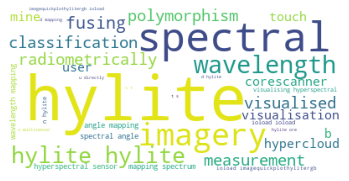

In [62]:
img = WordCloud(background_color='white').generate(t17_words)
plt.imshow(img)
plt.axis('off')
plt.show()

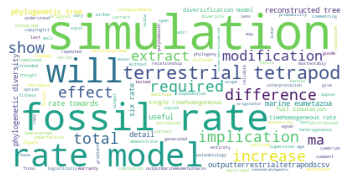

In [63]:
img = WordCloud(background_color='white').generate(t3_words)
plt.imshow(img)
plt.axis('off')
plt.show()

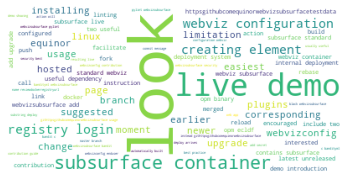

In [64]:
img = WordCloud(background_color='white').generate(t2_words)
plt.imshow(img)
plt.axis('off')
plt.show()

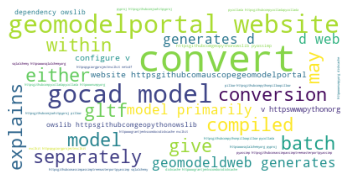

In [65]:
img = WordCloud(background_color='white').generate(t11_words)
plt.imshow(img)
plt.axis('off')
plt.show()

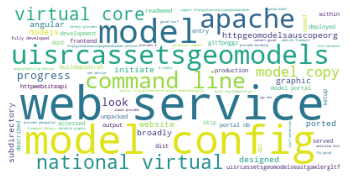

In [66]:
img = WordCloud(background_color='white').generate(t9_words)
plt.imshow(img)
plt.axis('off')
plt.show()

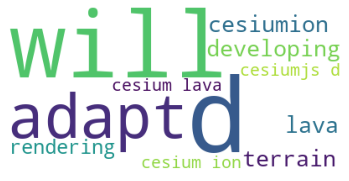

In [67]:
img = WordCloud(background_color='white').generate(t1_words)
plt.imshow(img)
plt.axis('off')
plt.show()

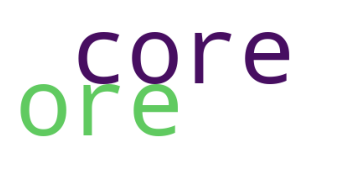

In [68]:
img = WordCloud(background_color='white').generate(t0_words)
plt.imshow(img)
plt.axis('off')
plt.show()

## Trying to make Gensim Library Work

In [69]:
text = "Nick likes to play football, however he is not too fond of tennis."
filtered_sentence = remove_stopwords(text)

print(filtered_sentence)

Nick likes play football, however fond tennis.


In [70]:
df4.head()


,language,text_filtered,doc_length,words,bigrams,trigrams,Topic
0,Jupyter Notebook,hylite hylite is an for imagery from a of hype...,172,"[hylite, hylite, is, an, for, imagery, fromof,...","[(hylite, hylite), (hylite, is), (is, an), (an...","[(hylite, hylite, is), (hylite, is, an), (is, ...",17
1,Python,webviz subsurface live demo introduction this ...,292,"[webviz, subsurface, live, demo, introduction,...","[(webviz, subsurface), (subsurface, live), (li...","[(webviz, subsurface, live), (subsurface, live...",2
2,R,an that a logistic model to simulated phylogen...,753,"[an, thatlogistic, model, to, simulated, phylo...","[(an, that), (that, a), (a, logistic), (logist...","[(an, that, a), (that, a, logistic), (a, logis...",3
3,JavaScript,a d is the d of at it is and on the cesiumjs d...,61,"[ais, theof, at, it, is, and, on, the, cesiumj...","[(a, d), (d, is), (is, the), (the, d), (d, of)...","[(a, d, is), (d, is, the), (is, the, d), (the,...",1
4,Python,geomodeldweb generates d web of model primaril...,164,"[geomodeldweb, generatesweb, of, model, primar...","[(geomodeldweb, generates), (generates, d), (d...","[(geomodeldweb, generates, d), (generates, d, ...",11


In [71]:
df['Gensim_Clean'] = df['text_filtered'].apply(remove_stopwords)
df

,language,content,date,text_cleaned,text_tokenized,text_lemmatized,text_filtered,Gensim_Clean
0,Jupyter Notebook,hylite\nhylite is an open-source python packag...,2020-11-27 17:31:07.762,hylite\nhylite is an opensource python package...,hylite\nhylite is an opensource python package...,hylite hylite is an opensource python package ...,hylite hylite is an for imagery from a of hype...,hylite hylite imagery hyperspectral sensor fus...
1,Python,\n\n\n\n\n\nWebviz subsurface\n\n✨👓 Live demo ...,2020-11-27 17:31:08.305,\n\n\n\n\n\nwebviz subsurface\n\n live demo ap...,webviz subsurface\n\n live demo application\n\...,webviz subsurface live demo application introd...,webviz subsurface live demo introduction this ...,webviz subsurface live demo introduction conta...
2,R,"Reforester\nReforester, an R program that:\n\n...",2020-11-27 17:31:08.926,reforester\nreforester an r program that\n\nus...,reforester\nreforester an r program that\n\nus...,reforester reforester an r program that us a l...,an that a logistic model to simulated phylogen...,logistic model simulated phylogenetic tree her...
3,JavaScript,Swissgeol NGM\nA Geology 3D viewer\nSwissgeol ...,2020-11-27 17:31:09.532,swissgeol ngm\na geology d viewer\nswissgeol i...,swissgeol ngm\na geology d viewer\nswissgeol i...,swissgeol ngm a geology d viewer swissgeol is ...,a d is the d of at it is and on the cesiumjs d...,cesiumjs adapt developing lava cesium ion cesi...
4,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,2020-11-27 17:31:10.206,geomodeldweb\n\ngenerates d web versions of ge...,geomodeldweb\n\ngenerates d web versions of ge...,geomodeldweb generates d web version of geolog...,geomodeldweb generates d web of model primaril...,geomodeldweb generates web model primarily geo...
...,...,...,...,...,...,...,...,...
1836,Jupyter Notebook,hylite\nhylite is an open-source python packag...,2020-11-27 17:49:28.816,hylite\nhylite is an opensource python package...,hylite\nhylite is an opensource python package...,hylite hylite is an opensource python package ...,hylite hylite is an for imagery from a of hype...,hylite hylite imagery hyperspectral sensor fus...
1837,Python,\n\n\n\n\n\nWebviz subsurface\n\n✨👓 Live demo ...,2020-11-27 17:49:29.111,\n\n\n\n\n\nwebviz subsurface\n\n live demo ap...,webviz subsurface\n\n live demo application\n\...,webviz subsurface live demo application introd...,webviz subsurface live demo introduction this ...,webviz subsurface live demo introduction conta...
1838,R,"Reforester\nReforester, an R program that:\n\n...",2020-11-27 17:49:29.385,reforester\nreforester an r program that\n\nus...,reforester\nreforester an r program that\n\nus...,reforester reforester an r program that us a l...,an that a logistic model to simulated phylogen...,logistic model simulated phylogenetic tree her...
1839,JavaScript,Swissgeol NGM\nA Geology 3D viewer\nSwissgeol ...,2020-11-27 17:49:29.656,swissgeol ngm\na geology d viewer\nswissgeol i...,swissgeol ngm\na geology d viewer\nswissgeol i...,swissgeol ngm a geology d viewer swissgeol is ...,a d is the d of at it is and on the cesiumjs d...,cesiumjs adapt developing lava cesium ion cesi...


In [72]:
from gensim.parsing.preprocessing import remove_stopwords

def basic_clean(text):
    '''
    Initial basic cleaning/normalization of text string
    '''
    # change to all lowercase
    low_case = text.lower()
    # remove special characters, encode to ascii and recode to utf-8
    recode = unicodedata.normalize('NFKD', low_case).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Remove numbers from text
    cleaned = re.sub(r'\d+', '', recode)
    # Replace anything that is not a letter, number, whitespace or a single quote
    cleaned = re.sub(r"[^a-z0-9'\s]", '', cleaned)
    return cleaned

def tokenize(text):
    '''
    Use NLTK TlktokTokenizer to seperate/tokenize text
    '''
    # create the NLTK tokenizer object
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(text, return_str=True)

def stem(text):
    '''
    Apply NLTK stemming to text to remove prefix and suffixes
    '''
    # Create the nltk stemmer object, then use it
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in text.split()]
    article_stemmed = ' '.join(stems)
    return article_stemmed

def lemmatize(text):
    '''
    Apply NLTK lemmatizing to text to remove prefix and suffixes
    '''
    # Create the nltk lemmatize object, then use it
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in text.split()]
    article_lemmatized = ' '.join(lemmas)
    return article_lemmatized

def remove_extra_words(text):
    '''
    Removes stopwords from text, allows for additional words to exclude, or words to not exclude
    '''
    # define additional words
    extra_words=['accessing',
     'according',
     'account',
     'accuracy',
     'accurate',
     'acknowledgement',
     'acquired',
     'across',
     'activate',
     'addition',
     'additional',
     'adhere',
     'adheres',
     'aim',
     'al',
     'along',
     'also',
     'alternative',
     'anacona',
     'anaconda',
     'analyse',
     'analysed',
     'analysis',
     'andor',
     'answer',
     'appearance',
     'application',
     'assetids',
     'associated',
     'assumption',
     'attempt',
     'author',
     'automated',
     'automatic',
     'available',
     'based',
     'behavior',
     'behaviour',
     'benson',
     'better',
     'bias',
     'biased',
     'billie',
     'birthdeath',
     'bug',
     'calculated',
     'cannot',
     'caper',
     'capture',
     'carried',
     'cause',
     'cc',
     'cd',
     'check',
     'cite',
     'citing',
     'clone',
     'closer',
     'cloud',
     'cloudquickplotcloudheadergetcamera',
     'code',
     'coma',
     'commented',
     'common',
     'compared',
     'complete',
     'completeness',
     'conda',
     'consistently',
     'console',
     'contributing',
     'conventionally',
     'cool',
     'copytxt',
     'corescannerhypercloud',
     'corrected',
     'correction',
     'could',
     'count',
     'cpu',
     'create',
     'created',
     'currently',
     'daniel',
     'data',
     'database',
     'dataimporterr',
     'datasets',
     'default',
     'define',
     'derivative',
     'design',
     'desired',
     'detailed',
     'dev',
     'developingmd',
     'different',
     'difficult',
     'dimensionality',
     'directory',
     'disable',
     'disables',
     'display',
     'dissertation',
     'diversitydependent',
     'documentation',
     'doe',
     'download',
     'downloading',
     'dtilesets',
     'due',
     'earth',
     'easily',
     'efficiently',
     'eg',
     'empirical',
     'end',
     'enforce',
     'entierty',
     'enviroment',
     'environment',
     'equilibrium',
     'error',
     'estimate',
     'estimation',
     'et',
     'even',
     'example',
     'except',
     'explosion',
     'exponentially',
     'exponentiallydiversifying',
     'extant',
     'extend',
     'factor',
     'fast',
     'feature',
     'feel',
     'file',
     'find',
     'fine',
     'fix',
     'following',
     'format',
     'foundation',
     'free',
     'function',
     'functionssavesetsr',
     'functionsuniformsamplingr',
     'gdal',
     'general',
     'generate',
     'generating',
     'geological',
     'geology',
     'get',
     'getting',
     'git',
     'github',
     'gnu',
     'google',
     'ground',
     'ha',
     'happy',
     'hardcoded',
     'high',
     'highresolution',
     'history',
     'hope',
     'httplocalhost',
     'httpsbetaswissgeolch',
     'httpsgithubcomswissgeolngmgit',
     'httpshylitereadthedocsioenlatestindexhtml',
     'httpsopengameartorgcontenttemplateorangetexturepack',
     'httpswwwgnuorglicenses',
     'hylitergb',
     'hyperclouds',
     'id',
     'idea',
     'image',
     'imagine',
     'implemented',
     'implied',
     'import',
     'inaccurate',
     'included',
     'includes',
     'including',
     'indicate',
     'inferred',
     'information',
     'initialscreenspaceerror',
     'inspector',
     'install',
     'installation',
     'installed',
     'integrated',
     'integration',
     'introduces',
     'inverse',
     'io',
     'ioloadtestdatahypercloudplycloudquickplotcloudheadergetcamera',
     'ioloadtestdataimagehdrimagequickplothylitergb',
     'ioloadtestdatalibrarycsvlibquickplot',
     'issue',
     'json',
     'jupyter',
     'key',
     'keyboard',
     'keyboardlayouteditor',
     'know',
     'laboratory',
     'launch',
     'launching',
     'layout',
     'learning',
     'least',
     'length',
     'level',
     'lib',
     'libquickplot',
     'library',
     'licencemd',
     'license',
     'limit',
     'lineagecombining',
     'list',
     'local',
     'localhost',
     'long',
     'longheld',
     'lorenz',
     'machine',
     'made',
     'maintainerpackage',
     'make',
     'many',
     'map',
     'marineeumetazoacsv',
     'mark',
     'marker',
     'marking',
     'matplotlib',
     'maximum',
     'maximumscreenspaceerror',
     'merchantability',
     'method',
     'mind',
     'minimum',
     'modify',
     'multiscale',
     'must',
     'myr',
     'myrs',
     'navigate',
     'navigation',
     'need',
     'new',
     'next',
     'ngm',
     'nolimit',
     'nolimitfalse',
     'norequestrendermode',
     'note',
     'notebook',
     'npm',
     'number',
     'numpy',
     'occurrence',
     'one',
     'open',
     'opencv',
     'opening',
     'openpit',
     'opensource',
     'operation',
     'optimization',
     'optional',
     'order',
     'originatorclose',
     'ouput',
     'outdoor',
     'ownterrainfalse',
     'oxford',
     'package',
     'parameter',
     'partially',
     'particular',
     'past',
     'pattern',
     'pde',
     'pdes',
     'perform',
     'performed',
     'phytools',
     'pip',
     'placed',
     'please',
     'point',
     'pointcloud',
     'possible',
     'potential',
     'preform',
     'preprocessing',
     'prerequisitev',
     'prerequisitewindowv',
     'present',
     'prevented',
     'problem',
     'processing',
     'produce',
     'produce ',
     'produced',
     'program',
     'project',
     'project ',
     'prompt',
     'properly',
     'provide',
     'provided',
     'proxy',
     'public',
     'publically',
     'published',
     'pull',
     'purpose',
     'python',
     'quality',
     'question',
     'r',
     'rather',
     'raw',
     'readme',
     'received',
     'recent',
     'record',
     'rectangle',
     'redistribute',
     'reduction',
     'refer',
     'reference',
     'referred',
     'reforester',
     'regime',
     'reinterpretation',
     'report',
     'repository',
     'request',
     'requires',
     'research',
     'resource',
     'respectively',
     'restrict',
     'restriction',
     'result',
     'results',
     'reults',
     'review',
     'rigorous',
     'rock',
     'roger',
     'run',
     'running',
     'said',
     'sample',
     'sampled',
     'sampling',
     'scan',
     'scene',
     'script',
     'seamless',
     'second',
     'section',
     'see',
     'separated',
     'server',
     'set',
     'setuppy',
     'setuptools',
     'significant',
     'significantly',
     'similarly',
     'simple',
     'slight',
     'software',
     'solved',
     'source',
     'specie',
     'specific',
     'specifically',
     'sphere',
     'start',
     'started',
     'stay',
     'step',
     'still',
     'study',
     'style',
     'submit',
     'sufficiently',
     'suggests',
     'supervised',
     'sure',
     'swiss',
     'swissgeol',
     'swissrectangle',
     'swissrectanglefalse',
     'swisstopo',
     'take',
     'technique',
     'technology',
     'template',
     'templatelogistic',
     'templatenotebooks',
     'term',
     'terminal',
     'test',
     'testdatahypercloudply',
     'testdataimagehdr',
     'testdatalibrarycsv',
     'testing',
     'texture',
     'theoretically',
     'thereby',
     'thiele',
     'thing',
     'thompson',
     'though',
     'tidyverse',
     'time',
     'timeheterogeneous',
     'tool',
     'touchdirectly',
     'true',
     'try',
     'trying',
     'tuned',
     'type',
     'typing',
     'ubiquity',
     'understanding',
     'unfortunately',
     'unsupervised',
     'unzip',
     'url',
     'us',
     'use',
     'used',
     'userhylite',
     'userhyliterequired',
     'using',
     'value',
     'variety',
     'vast',
     'version',
     'viewed',
     'viewer',
     'visual',
     'wa',
     'want',
     'way',
     'welcome',
     'welcomed',
     'widget',
     'window',
     'word',
     'work',
     'workflowworkflow']
    words = text.split()
    # filter the words
    filtered_words = [w for w in words if w not in extra_words]
    # print number of stopwords removed
    #print('Removed {} stopwords'.format(len(words) - len(filtered_words)))
    # produce string without stopwords
    article_without_stopwords = ' '.join(filtered_words)
    return article_without_stopwords


###### my GitHub version
def prep_data3(df, column):
    '''
    This function take in a df and the string name for a text column with 
    option to pass lists for extra_words and exclude_words and
    returns a df with the text article title, original text, stemmed text,
    lemmatized text, cleaned, tokenized, & lemmatized text with stopwords removed.
    '''
    # create column with text cleaned
#     df['clean'] = df[column].apply(basic_clean)\
#                             .apply(tokenize)\
#                             .apply(lemmatize)\
#                             .apply(remove_stopwords)
                                   
    # basic clean, tokenize, remove_stopwords, and stem text
    df['content_clean'] = df[column].apply(basic_clean)\
                                    .apply(tokenize)\
                                    .apply(lemmatize)\
                                    .apply(remove_stopwords)\
                                    .apply(remove_extra_words)

    # add a column with a list of words
    words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.content_clean]

    # column name will be words, and the column will contain lists of the words in each doc
    df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)
    # add column with number of words in readme content
    df['doc_length'] = [len(wordlist) for wordlist in df.words]
    
    # Adds column with bigrams and trigrams
    #df['bigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.ngrams(row.split(), 2)))
    #df['bigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.bigrams(row.split(' '))))
    #df['trigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.trigrams(row.split(' '))))
    
    # removing non-english languages 
    language_list = ['JavaScript', 'R', 'Jupyter Notebook','Python','TypeScript']
    df = df[df.language.isin(language_list)]
    
    # Specify dataframe content
    df = df[['language','content','content_clean','doc_length','words']]
    return df

In [73]:

df = acquire.get_github_geology_results(cached=True)
df5 = prep_data3(df, 'content')
df5.head()

,language,content,content_clean,doc_length,words
0,Jupyter Notebook,hylite\nhylite is an open-source python packag...,hylite hylite imagery hyperspectral sensor fus...,52,"[hylite, hylite, imagery, hyperspectral, senso..."
1,Python,\n\n\n\n\n\nWebviz subsurface\n\n✨👓 Live demo ...,webviz subsurface live demo introduction conta...,144,"[webviz, subsurface, live, demo, introduction,..."
2,R,"Reforester\nReforester, an R program that:\n\n...",logistic model simulated phylogenetic tree tre...,293,"[logistic, model, simulated, phylogenetic, tre..."
3,JavaScript,Swissgeol NGM\nA Geology 3D viewer\nSwissgeol ...,d d cesiumjs d adapt developing lava cesium io...,10,"[dcesiumjsadapt, developing, lava, cesium, ion..."
4,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,geomodeldweb generates d web model primarily g...,103,"[geomodeldweb, generatesweb, model, primarily,..."


In [97]:
count_vect = CountVectorizer(max_df=.8, min_df=3, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df5['content_clean'].values.astype('U'))
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)
topic_values = LDA.transform(doc_term_matrix)
df5['Topic'] = topic_values.argmax(axis=1)
df5.head()

,language,content,content_clean,doc_length,words,Topic
0,Jupyter Notebook,hylite\nhylite is an open-source python packag...,hylite hylite imagery hyperspectral sensor fus...,52,"[hylite, hylite, imagery, hyperspectral, senso...",3
1,Python,\n\n\n\n\n\nWebviz subsurface\n\n✨👓 Live demo ...,webviz subsurface live demo introduction conta...,144,"[webviz, subsurface, live, demo, introduction,...",0
2,R,"Reforester\nReforester, an R program that:\n\n...",logistic model simulated phylogenetic tree tre...,293,"[logistic, model, simulated, phylogenetic, tre...",3
3,JavaScript,Swissgeol NGM\nA Geology 3D viewer\nSwissgeol ...,d d cesiumjs d adapt developing lava cesium io...,10,"[dcesiumjsadapt, developing, lava, cesium, ion...",3
4,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,geomodeldweb generates d web model primarily g...,103,"[geomodeldweb, generatesweb, model, primarily,...",4


In [98]:
df5.language.value_counts()

Python              463
Jupyter Notebook    460
R                   232
TypeScript          229
JavaScript          229
Name: language, dtype: int64

In [99]:
df5.Topic.value_counts()

3    693
0    460
4    231
1    229
Name: Topic, dtype: int64

In [101]:
t3 = df5[df5.Topic==3]
t3.head()

,language,content,content_clean,doc_length,words,Topic
0,Jupyter Notebook,hylite\nhylite is an open-source python packag...,hylite hylite imagery hyperspectral sensor fus...,52,"[hylite, hylite, imagery, hyperspectral, senso...",3
2,R,"Reforester\nReforester, an R program that:\n\n...",logistic model simulated phylogenetic tree tre...,293,"[logistic, model, simulated, phylogenetic, tre...",3
3,JavaScript,Swissgeol NGM\nA Geology 3D viewer\nSwissgeol ...,d d cesiumjs d adapt developing lava cesium io...,10,"[dcesiumjsadapt, developing, lava, cesium, ion...",3
8,Jupyter Notebook,hylite\nhylite is an open-source python packag...,hylite hylite imagery hyperspectral sensor fus...,52,"[hylite, hylite, imagery, hyperspectral, senso...",3
10,R,"Reforester\nReforester, an R program that:\n\n...",logistic model simulated phylogenetic tree tre...,293,"[logistic, model, simulated, phylogenetic, tre...",3


# Bad Scrape, Need to Fix

In [108]:
import pandas as pd
import numpy as np
import datetime as dt
from requests import get
from bs4 import BeautifulSoup
import os
import time

def make_soup(url):
    '''
    This helper function takes in a url and requests and parses HTML
    returning a soup object.
    '''
    # set headers and response variables
    headers = {'User-Agent': 'Codeup Data Science'} 
    response = get(url, headers=headers)
    # use BeartifulSoup to make object
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

def github_geology_urls():
    '''
    This function scrapes all of the urls from
    the github search page and returns a list of the most recently updated Geology urls.
    '''
    # get the first 500 pages to allow for those that don't have readme or language
    pages = range(1, 500)
    urls = []
    
    for p in pages:
        
        # format string of the base url for the main github search page we are using to update with page number
        url = f'https://github.com/search?{p}o=desc&q=geology&s=updated&type=Repositories'
        
        https://github.com/search?%7Bp%7Do=desc&p=1&q=geology&s=updated&type=Repositories
        https://github.com/search?%7Bp%7Do=desc&p=3&q=geology&s=updated&type=Repositories    

        # Make request and soup object using helper
        soup = make_soup(url)

        # Create a list of the anchor elements that hold the urls on this search page
        page_urls_list = soup.find_all('a', class_='v-align-middle')
        # for each url in the find all list get just the 'href' link
        page_urls = {link.get('href') for link in page_urls_list}
        # make a list of these urls
        page_urls = list(page_urls)
        # append the list from the page to the full list to return
        urls.append(page_urls)
        time.sleep(5)
        
    # flatten the urls list
    urls = [y for x in urls for y in x]
    return urls

In [110]:
urls = github_geology_urls()
urls

['/speleophysics/Math-modeling-2020',
 '/phantomjinx/evotempus',
 '/inkenbrandt/HydroStarContents',
 '/geodesymiami/rsmas_insar',
 '/lanl/LaGriT',
 '/AuScope/geomodel-2-3dweb',
 '/JustinGOSSES/wellio.js',
 '/geolba/GeotiefExplore',
 '/usgs/best-practices',
 '/geoffrowland/quantocks',
 '/speleophysics/Math-modeling-2020',
 '/phantomjinx/evotempus',
 '/inkenbrandt/HydroStarContents',
 '/geodesymiami/rsmas_insar',
 '/lanl/LaGriT',
 '/AuScope/geomodel-2-3dweb',
 '/JustinGOSSES/wellio.js',
 '/geolba/GeotiefExplore',
 '/usgs/best-practices',
 '/geoffrowland/quantocks',
 '/speleophysics/Math-modeling-2020',
 '/phantomjinx/evotempus',
 '/inkenbrandt/HydroStarContents',
 '/geodesymiami/rsmas_insar',
 '/lanl/LaGriT',
 '/AuScope/geomodel-2-3dweb',
 '/JustinGOSSES/wellio.js',
 '/geolba/GeotiefExplore',
 '/usgs/best-practices',
 '/geoffrowland/quantocks',
 '/speleophysics/Math-modeling-2020',
 '/phantomjinx/evotempus',
 '/inkenbrandt/HydroStarContents',
 '/geodesymiami/rsmas_insar',
 '/lanl/LaGriT'

In [ ]:
#url list staved for prosperitys sake
# ['/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  '/speleophysics/Math-modeling-2020',
#  '/phantomjinx/evotempus',
#  '/inkenbrandt/HydroStarContents',
#  '/geodesymiami/rsmas_insar',
#  '/lanl/LaGriT',
#  '/AuScope/geomodel-2-3dweb',
#  '/JustinGOSSES/wellio.js',
#  '/geolba/GeotiefExplore',
#  '/usgs/best-practices',
#  '/geoffrowland/quantocks',
#  ...]

# If urls Run, this function should return a corpus to use

In [129]:
def get_geo_corpus(cached=False):
    '''
    This function with default cached == False does a fresh scrape of github pages returned from
    search of 'environmental' and writes the returned df to a json file.
    cached == True returns a df read in from a json file.
    '''
    # option to read in a json file instead of scrape for df
    if cached == True:
        df = pd.read_json('georead.json')
        
    # cached == False completes a fresh scrape for df    
    else:
        # get url list
        url_list = urls

        # Set base_url that will be used in get request
        base_url = 'https://github.com'
        
        # List of full url needed to get readme info
        readme_url_list = []
        for url in url_list:
            full_url = base_url + url
            readme_url_list.append(full_url)
        
        # Create an empty list, readmes, to hold our dictionaries
        readmes = []

        for readme_url in readme_url_list:
            # Make request and soup object using helper
            soup = make_soup(readme_url)

            if soup.find('article', class_="markdown-body entry-content container-lg") != None:            
                # Save the text in each readme to variable text
                content = soup.find('article', class_="markdown-body entry-content container-lg").text
            
            if soup.find('span', class_="text-gray-dark text-bold mr-1") != None:
            # Save the first language in each readme to variable text
                # NOTE: this is the majority language, not all of the languages used
                language = soup.find('span', class_="text-gray-dark text-bold mr-1").text

                # anything else useful on the page?

                # Create a dictionary holding the title and content for each blog
                readme = {'language': language, 'content': content}

                # Add each dictionary to the articles list of dictionaries
                readmes.append(readme)
            
        # convert our list of dictionaries to a df
        df = pd.DataFrame(readmes)
        
        # Write df to a json file for faster access
        df.to_json('georead.json')
            

In [130]:
df = get_geo_corpus(cached=False)
df.head()

KeyboardInterrupt: 

In [115]:
df = df[df.language =='Python']
df.head(20)

,language,content
2,Python,RSMAS InSAR code\nThe Miami INterferometric SA...
4,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...
11,Python,RSMAS InSAR code\nThe Miami INterferometric SA...
13,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...
20,Python,RSMAS InSAR code\nThe Miami INterferometric SA...
22,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...
29,Python,RSMAS InSAR code\nThe Miami INterferometric SA...
31,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...
38,Python,RSMAS InSAR code\nThe Miami INterferometric SA...
40,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...
